In [1]:
FOLD = 0


import os
import time
import math
import requests

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]=str(FOLD)

try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse

import numpy as np
import pandas as pd

import mlcrate as mlc

import os

import cv2

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score

from skimage.transform import resize

from tqdm import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.optim import Optimizer
from torch.utils.data import Dataset, DataLoader
import torch.utils.checkpoint as checkpoint

import torchvision
from torchvision import transforms, utils

import apex
from apex.fp16_utils import FP16_Optimizer

from torchsummary import summary

from tensorboardX import SummaryWriter

SEED = 1337

NOTIFY_EACH_EPOCH = False

WORKERS = 24
BATCH_SIZE = 256

N_SPLITS = 8
SUBSET_SIZE = 1000000
SUBSET_CLASSES = 1000

np.random.seed(SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

writer = SummaryWriter()

def log(tag, value, iteration, multiple_scalars=False):
    if multiple_scalars == True:
        writer.add_scalars(f'data/{tag}', value, iteration)
    else:
        writer.add_scalar(f'data/{tag}', value, iteration)

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

# from https://github.com/floydhub/save-and-resume
def save_checkpoint(state):
    """Save checkpoint if a new best is achieved"""
    print ("Saving checkpoint")

    filename = f'./checkpoint/checkpoint-{state["epoch"]}.pt.tar'
    torch.save(state, filename)
    
def initialize(path, model, optimizer=None):    
    checkpoint = torch.load(path)

    model.load_state_dict(checkpoint['model'])

    print(f'loaded checkpoint {path} | Trained for {checkpoint["epoch"] + 1} epochs')
    
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer'])
          
        epoch = checkpoint['epoch'] + 1
        train_iteration = checkpoint['train_iteration']
        val_iteration = checkpoint['val_iteration']

        return model, optimizer, epoch, train_iteration, val_iteration
    else:
        return model
    
KEY = 'iDCO9Ns00jOTY_Db3KuaVLhjux-HKPp_tEtV8LEtesP'

def notify(title, message, key=KEY):
    report = {}
    report['value1'] = title
    report['value2'] = message

    requests.post(f'https://maker.ifttt.com/trigger/notify/with/key/{key}', data=report)

using non-fused syncBN, try install apex with 'python setup.py install --cuda_ext' to enable fused syncBN for better performance


In [2]:
classes_trainable = pd.read_csv('/home/kaggle/.kaggle/inclusive-images/classes-trainable.csv')
train_human_labels = pd.read_csv('/home/kaggle/.kaggle/inclusive-images/train_human_labels.csv')
stage_1_sample_submission = pd.read_csv('/home/kaggle/.kaggle/inclusive-images/stage_1_sample_submission.csv')
class_descriptions = pd.read_csv('/home/kaggle/.kaggle/inclusive-images/class-descriptions.csv')

In [3]:
top_k = train_human_labels.LabelName.value_counts()[:SUBSET_CLASSES].index.values
train_human_labels = train_human_labels[train_human_labels.LabelName.isin(top_k)].reset_index(drop=True)

# only keep trainable labels in train_human_labels
# train_human_labels = train_human_labels[train_human_labels.LabelName.isin(temp)].reset_index()
train_human_labels = train_human_labels[train_human_labels.LabelName.isin(classes_trainable.label_code.values)].reset_index(drop=True)

# get indices for all rows and labels for indices
indices, labels = pd.factorize(train_human_labels.LabelName)
# train_human_labels['indices'] = indices
# train_human_labels['indices'] = train_human_labels['indices'].astype(str)

# train = train_human_labels.groupby(train_human_labels['ImageID'])['indices'].apply(' '.join).reset_index()
# train.to_csv('../../data/train_1k_classes.csv')

train = pd.read_csv('../../data/train_1k_classes.csv')

In [4]:
class ImagesDataset(Dataset):
    def __init__(self, df, root_path, train=True, size=256, img_id_col_name='ImageID', n_classes=7172):
        self.size = size
        self.n_classes = n_classes

        self.root_path = root_path

        self.df = df
        self.train = train

        self.img_id_col_name = img_id_col_name

        self.ids = self.df[self.img_id_col_name].values#.unique()
        
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        
        if self.train is True:
            img_path = os.path.join(self.root_path, f'train_{img_id[0]}', f'{img_id}.jpg')
        else:
            img_path = os.path.join(self.root_path, f'{img_id}.jpg')
            
        img = cv2.imread(img_path)
        img = cv2.resize(img, (self.size, self.size))
        img = np.float32(img)
        img /= 255
        img = img.reshape(3, self.size, self.size)
        img = torch.from_numpy(img)
        
        if self.train is True:
            labels = list(map(int, self.df.iloc[idx].indices.split(' ')))
                        
            one_hot_labels = torch.zeros((self.n_classes))
            one_hot_labels[labels] = 1
            one_hot_labels = one_hot_labels
            
            sample = {'img': img, 'label': one_hot_labels}
        else:
            sample = {'img': img}
        
        return sample

In [5]:
class ResNet(nn.Module):
    def __init__(self, out_ch=7172, pretrained=False):
        super(ResNet, self).__init__()
        
        self.resnet = torchvision.models.resnet50(pretrained=pretrained)
    
        self.fe = nn.Sequential(
            self.resnet.conv1,
            self.resnet.bn1,
            self.resnet.relu,
            self.resnet.maxpool,
            self.resnet.layer1,
            self.resnet.layer2,
            self.resnet.layer3,
            self.resnet.layer4
        )
        
        self.avgpool = nn.AvgPool2d(8)
        
        self.logit = nn.Linear(2048, out_ch)

    def forward(self, x):
        x = self.fe(x)
        
        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)

        x = self.logit(x)
        
        return x

In [6]:
# from https://becominghuman.ai/investigating-focal-and-dice-loss-for-the-kaggle-2018-data-science-bowl-65fb9af4f36c
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        # Inspired by the implementation of binary_cross_entropy_with_logits
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()
        # This formula gives us the log sigmoid of 1-p if y is 0 and of p if y is 1
        invprobs = F.logsigmoid(-input * (target * 2 - 1)) 
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

# from https://www.kaggle.com/anokas/fixed-f2-score-in-python
def f2_score(y_true, y_pred):
    # fbeta_score throws a confusing error if inputs are not numpy arrays
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    # We need to use average='samples' here, any other average method will generate bogus results
    return fbeta_score(y_true, y_pred, beta=2, average='samples')

In [7]:
# use subset of 100k images
kfold = KFold(n_splits=50, shuffle=True, random_state=SEED)
subset = np.random.choice(train['ImageID'], SUBSET_SIZE)

train_idx, val_idx = list(kfold.split(subset))[FOLD]
x_train, x_val = train.iloc[train_idx], train.iloc[val_idx]

train_dataset = ImagesDataset(x_train, '/home/kaggle/.kaggle/inclusive-images/train', n_classes=SUBSET_CLASSES)
val_dataset = ImagesDataset(x_val, '/home/kaggle/.kaggle/inclusive-images/train', n_classes=SUBSET_CLASSES)
test_dataset = ImagesDataset(stage_1_sample_submission, '/home/kaggle/.kaggle/inclusive-images/stage-1-test-images', train=False, img_id_col_name='image_id', n_classes=SUBSET_CLASSES)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

y_val = mlc.load('../../data/y_val_subset_1k_classes_1m_images_50_folds.pkl.gz')
# y_val = np.zeros((len(val_dataset), SUBSET_CLASSES))

# for i, val in tqdm(enumerate(val_dataset), total=len(val_dataset)):
#     y_val[i] = val['label']

# mlc.save(y_val, '../../data/y_val_subset_1k_classes_1m_images_50_folds.pkl.gz')

print(f'Train Dataset: {len(train_dataset)}')
print(f'Val Dataset: {len(val_dataset)}')
print(f'Test Dataset: {len(test_dataset)}')

Train Dataset: 980000
Val Dataset: 20000
Test Dataset: 32580


In [8]:
def view(idx, dataset, preds, test=False):
    plt.imshow(dataset[idx]['img'].reshape(256, 256, 3))
    if test == False:
        print(class_descriptions[class_descriptions['label_code'].isin(labels[list(np.where(dataset[idx]['label'] == 1)[0])])].reset_index())
    print(class_descriptions[class_descriptions['label_code'].isin(labels[list(np.where(preds[idx] == 1)[0])])].reset_index())

In [9]:
def find_lr(train_dataloader, init_value=1e-8, final_value=10., beta=0.98):
    model = ResNet(out_ch=SUBSET_CLASSES).to(device).half()
    model = nn.DataParallel(model)

    optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4)
    optimizer = FP16_Optimizer(optimizer, dynamic_loss_scale=True, verbose=False)

    criterion = nn.BCEWithLogitsLoss()
    
    num = len(train_dataloader)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    for i, batch in tqdm(enumerate(train_dataloader), total=(int(len(train_dataset) / BATCH_SIZE))):
        batch_num += 1

        img, label = batch['img'].to(device).half(), batch['label'].float().to(device).half()

        optimizer.zero_grad()
        out = model(img)
        loss = criterion(out, label)
        
        avg_loss = beta * avg_loss + (1-beta) *loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        
        optimizer.backward(loss)
        optimizer.step()
        
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr

    return log_lrs, losses

In [10]:
start_epoch = 0
epochs = 50
early_stopping = 5

train_iteration = 0
val_iteration = 0

threshold = 0.2

model = ResNet(out_ch=SUBSET_CLASSES).to(device).half()
model = nn.DataParallel(model, device_ids=[0, 1])

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
optimizer = FP16_Optimizer(optimizer, dynamic_loss_scale=True, verbose=False)

criterion = nn.BCELoss()

model, optimizer, start_epoch, train_iteration, val_iteration = initialize('./checkpoint/checkpoint-11.pt.tar', model, optimizer)

optimizer.param_groups[0]['lr'] = 0.01

# summary(model, input_size=(3, 256, 256))

loaded checkpoint ./checkpoint/checkpoint-11.pt.tar | Trained for 12 epochs


In [ ]:
best_train_loss = 1e10
best_val_loss = 1e10

best_train_f2 = 0
best_val_f2 = 0

best_epoch = 0

for epoch in range(start_epoch, epochs):
    print(f'\n Starting Epoch {epoch} | LR: {optimizer.param_groups[0]["lr"]}')
        
    train_loss = 0
    val_loss = 0

    train_iou = 0
    val_iou = 0

    model.train()
    for i, batch in tqdm(enumerate(train_dataloader), total=(int(len(train_dataset) / BATCH_SIZE))):
        img, label = batch['img'].to(device).half(), batch['label'].to(device).half()
          
        out = model(img)
        
        out = torch.sigmoid(out)
        loss = criterion(out, label)

        log('train_loss_iteration', loss.item(), train_iteration)
        train_loss += loss.item()

        optimizer.zero_grad()
        
        optimizer.backward(loss)
        optimizer.step()
          
        train_iteration += 1
          
    model.eval()
    with torch.no_grad():  
        val_preds = np.zeros((len(val_dataset), SUBSET_CLASSES), dtype=np.float32)
        for j, batch in tqdm(enumerate(val_dataloader), total=(int(len(val_dataset) / BATCH_SIZE))):
            img, label = batch['img'].to(device).half(), batch['label'].to(device).half()

            out = model(img)
            out = torch.sigmoid(out)

            loss = criterion(out, label)

            log('val_loss_iteration', loss.item(), val_iteration)
            val_loss += loss.item()

            optimizer.zero_grad()
          
            pred = out.to('cpu').detach().numpy()
            pred = pred.reshape(-1, SUBSET_CLASSES)
            val_preds[j*BATCH_SIZE:j*BATCH_SIZE+BATCH_SIZE] = pred
          
            val_iteration += 1

    val_preds_raw = val_preds
    val_preds = (val_preds > threshold).astype(int)

    train_loss /= (i + 1)
    val_loss /= (j + 1)
          
    train_f2 = 0
    val_f2 = f2_score(y_val, val_preds)
    
    log('lr', optimizer.param_groups[0]["lr"], epoch)
    
    log('epoch_loss', {'train_loss': train_loss, 'val_loss': val_loss}, epoch, multiple_scalars=True)
    log('epoch_f2', {'train_f2': train_f2, 'val_f2': val_f2}, epoch, multiple_scalars=True)
                  
    print(f' End of Epoch {epoch} | Train Loss: {train_loss} | Val Loss: {val_loss} | Train F2: {round(train_f2, 4)} | Val F2: {round(val_f2, 4)}')
    if NOTIFY_EACH_EPOCH:
        notify(f'Fold: {FOLD} | Epoch {epoch} Ended', f'Train Loss: {round(train_loss, 4)} | Val Loss: {round(val_loss, 4)} | Train F2: {round(train_f2, 4)} | Val F2: {round(val_f2, 4)}')
          
    scheduler.step(val_loss)
          
    if val_loss < best_val_loss:
        best_epoch = epoch

        best_train_loss = train_loss
        best_val_loss = val_loss

        best_train_f2 = train_f2
        best_val_f2 = val_f2
          
        save_checkpoint({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'train_iteration': train_iteration,
            'val_iteration': val_iteration
        })
        print(f'Val loss has decreased, saving model at epoch {epoch}')

    elif epoch - best_epoch > early_stopping:
        print(f' Val loss has not decreased for {early_stopping} epochs, stopping training')
        notify(f'Fold: {FOLD} | Early stopping at epoch {epoch}', f'Val loss has not decreased for {early_stopping} epochs, stopping training')
        break

In [ ]:
save_checkpoint({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'epoch': epoch,
    'train_iteration': train_iteration,
    'val_iteration': val_iteration
})

In [ ]:
notify(f'Fold: {FOLD} | Best Epoch: {best_epoch}', f'Best train Loss: {round(best_train_loss, 4)} | Best val Loss: {round(best_val_loss, 4)} | Best train F2: {round(best_train_f2, 4)} | \
Best Val F2: {round(best_val_f2, 4)}')

In [ ]:
model = ResNet(out_ch=SUBSET_CLASSES).to(device).half()
model = nn.DataParallel(model)
model = initialize('./checkpoint/checkpoint-17.pt.tar', model)

val_preds = np.zeros((len(val_dataset), SUBSET_CLASSES), dtype=np.float32)

model.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(val_dataloader), total=int(len(val_dataset) / BATCH_SIZE)):
        img = batch['img'].to(device).half()
        
        out = model(img)
        out = torch.sigmoid(out)
        pred = out.to('cpu').detach().numpy()
        pred = pred.reshape(-1, SUBSET_CLASSES)
        val_preds[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE] = pred

In [ ]:
def optimise_f2_thresholds(y, p, verbose=True, resolution=100, classes=100):
    def mf(x):
        p2 = np.zeros_like(p)
        for i in range(classes):
            p2[:, i] = (p[:, i] > x[i]).astype(np.int)
        score = fbeta_score(y, p2, beta=2, average='samples')
        return score

    x = [0.2]*classes
    for i in tqdm(range(classes)):
        best_i2 = 0
        best_score = 0
        for i2 in range(resolution):
            i2 /= resolution
            x[i] = i2
            score = mf(x)
            if score > best_score:
                best_i2 = i2
            best_score = score
        x[i] = best_i2
        if verbose:
            print(i, best_i2, best_score)
    return x

In [ ]:
thresholds = optimise_f2_thresholds(y_val, val_preds, verbose=False)
thresholds = np.array(thresholds)

In [ ]:
# val_preds_thresholded = (val_preds > thresholds).astype(int)
val_preds_thresholded = (val_preds > 0.1).astype(int)

In [ ]:
print(f2_score(y_val, val_preds_thresholded), precision_score(y_val, val_preds_thresholded, average='samples'), recall_score(y_val, val_preds_thresholded, average='samples'))

In [ ]:
view(2, val_dataset, val_preds_thresholded)

In [11]:
model = ResNet(out_ch=SUBSET_CLASSES).to(device).half()
model = nn.DataParallel(model)
model = initialize('./checkpoint/checkpoint-17.pt.tar', model)

preds = np.zeros((len(test_dataset), SUBSET_CLASSES), dtype=np.float32)

model.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_dataloader), total=int(len(test_dataset) / BATCH_SIZE)):
        img = batch['img'].to(device).half()
        
        out = model(img)
        out = torch.sigmoid(out)
        pred = out.to('cpu').detach().numpy()
        pred = pred.reshape(-1, SUBSET_CLASSES)
        preds[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE] = pred
        
# preds = (preds > thresholds).astype(int)
preds = (preds > threshold).astype(int)

loaded checkpoint ./checkpoint/checkpoint-17.pt.tar | Trained for 18 epochs


128it [00:34,  3.72it/s]                         


   index label_code description
0   1206  /m/01g317      Person
1  15243   /m/09j2d    Clothing


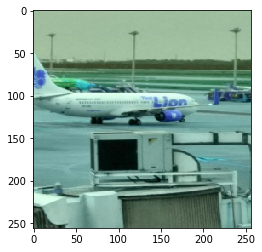

In [12]:
view(1, test_dataset, preds, test=True)

In [13]:
def submit(preds):
    pred_labels = []

    for pred in preds:
        pred_labels.append(labels[np.where(pred == 1)])

    pred_labels_string = []
    for pred_label in pred_labels:
        pred_labels_string.append(' '.join([i for i in pred_label]))
        
    submission = stage_1_sample_submission.copy()
    submission['labels'] = pred_labels_string
    
    mlc.kaggle.save_sub(submission, 'submission.csv')
    
    print(submission.head())

In [14]:
submit(preds)

                   image_id              labels
0  2b2b327132556c767a736b3d   /m/05s2s /m/07j7r
1  2b2b394755692f303963553d  /m/01g317 /m/09j2d
2  2b2b42584e6d445937444d3d   /m/05s2s /m/07j7r
3  2b2b44744e57674270616f3d   /m/05s2s /m/07j7r
4  2b2b4b425a592b683059493d                    


In [16]:
!kaggle competitions submit -c inclusive-images-challenge -f submission.csv -m "resnet 50 ik classes 1M images checkpoint 17 threshold 0.2"

100%|███████████████████████████████████████| 1.35M/1.35M [00:01<00:00, 808kB/s]
Successfully submitted to Inclusive Images Challenge